# Model: Logistic Regression

## Imports and Settings

In [1]:
# Helper libraries
import warnings
from itertools import combinations

# Scientific libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split

# Local Imports
from churn_detection.utils import get_feature_names
from churn_detection.data import load_data
from churn_detection.visualization import plot_confusion_table
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.features import (InteractionStrengthExtractor,
                                      FeatureConcatenator, 
                                      RareCategoryEncoder)
from churn_detection.paths import PARENT_DIR
from churn_detection.config import load_config
from churn_detection.models.ml_pipeline import create_pipeline
from churn_detection.models.experiment import ExperimentManager


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading and Preparing Data

In [2]:
churn = load_data()

In [3]:
preprocessed_data = preprocess_data(churn)
numeric_variables, categorical_variables = get_feature_names(preprocessed_data)

In [4]:
extractor = InteractionStrengthExtractor("partner", "paymentmethod", ordinal_encode=True)
extractor.fit(preprocessed_data)

new_preprocessed_data = extractor.transform(preprocessed_data)
strength_feature = extractor.get_strength_col_name()

discrete_vars_pairs = list(combinations(categorical_variables, 2))
concat_transformer = FeatureConcatenator(feature_pairs=discrete_vars_pairs)
concat_preprocessed_data = concat_transformer.transform(new_preprocessed_data)

In [5]:
prep_train, prep_test = train_test_split(
        concat_preprocessed_data, 
        test_size=0.2, 
        random_state=1
)

X_train, y_train = split_data(prep_train)
X_test, y_test = split_data(prep_test)

In [6]:
continuous_set = numeric_variables + [strength_feature]
discrete_set = categorical_variables + concat_transformer.get_new_feature_names()

## Model Training and Evaluation

In [7]:
config_dir = PARENT_DIR / "configs"
config = load_config(config_dir / "config.yaml")

In [8]:
# Numeric Features Configuration
config["feature_engineering"]["params"]["numerical"]["variables"] = continuous_set
config["feature_engineering"]["params"]["numerical"]["steps"] = [("scaler", RobustScaler(quantile_range=(40, 60)))]

# Categorical Features Configuration
config["feature_engineering"]["params"]["categorical"]["variables"] = discrete_set
config["feature_engineering"]["params"]["categorical"]["steps"] = [
        ("rarecat", RareCategoryEncoder(tol=0.2)),
        ("catencoder", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"))
]

In [9]:
lr_pipeline = create_pipeline(config)

In [10]:
lr_pipeline.train(X_train, y_train)

In [11]:
results = lr_pipeline.evaluate(X_test, y_test)
for metric, value in results.items():
    print(f"{metric}: {value:.3f}")

f1: 0.604
recall: 0.629


## Model Tuning and Tracking

We will explore hyperparameter tweaking, and the way to handle experiment outputs easier.

In [12]:
manager = ExperimentManager(
    create_pipeline(config), 
    experiment_name="churn_detection.lr_v7"
)

### Grid Search with Few Parameters

In [13]:
param_grid = {
    "C": [0.1, 1, 10], 
    "max_iter": [100, 200, 300]
}
grid_results = manager.grid_search(
    X_train, y_train, param_grid, scoring="recall", n_jobs=1
)
grid_results["best_params"]

2025-01-08 00:40:07,293 - experiment_manager.churn_detection.lr_v7 - INFO - Starting grid search for experiment churn_detection.lr_v7
2025-01-08 00:40:07,294 - experiment_manager.churn_detection.lr_v7 - INFO - Fitting grid search CV
2025-01-08 00:40:44,112 - experiment_manager.churn_detection.lr_v7 - INFO - Experiment saved
2025-01-08 00:40:44,121 - experiment_manager.churn_detection.lr_v7 - INFO - Model saved
2025-01-08 00:40:44,121 - experiment_manager.churn_detection.lr_v7 - INFO - Grid search completed.


{'C': 10, 'max_iter': 200}

### Grid Search with More Parameters

In [14]:
param_grid = {
    "C": [0.1, 1, 10, 100, 1000],
    "max_iter": [100, 200],
    "solver": ["saga", "liblinear"],
    "penalty": ["l1", "l2"],
}
grid_results = manager.grid_search(
    X_train, y_train, param_grid, scoring="recall", n_jobs=1
)
grid_results["best_params"]

2025-01-08 00:40:44,151 - experiment_manager.churn_detection.lr_v7 - INFO - Starting grid search for experiment churn_detection.lr_v7
2025-01-08 00:40:44,151 - experiment_manager.churn_detection.lr_v7 - INFO - Fitting grid search CV
2025-01-08 00:45:01,779 - experiment_manager.churn_detection.lr_v7 - INFO - Experiment saved
2025-01-08 00:45:01,786 - experiment_manager.churn_detection.lr_v7 - INFO - Model saved
2025-01-08 00:45:01,786 - experiment_manager.churn_detection.lr_v7 - INFO - Grid search completed.


{'C': 100, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [15]:
best_experiment = manager.get_best_experiment()

## Best Model on Test Data

In [16]:
manager.apply_best_params(best_experiment["experiment_id"])

In [17]:
manager.base_pipeline.train(X_train, y_train)

### Final Scores

In [18]:
results = manager.base_pipeline.evaluate(X_test, y_test)
for metric, value in results.items():
    print(f"{metric}: {value:.3f}")

f1: 0.603
recall: 0.647


### Confusion Table on Test Set

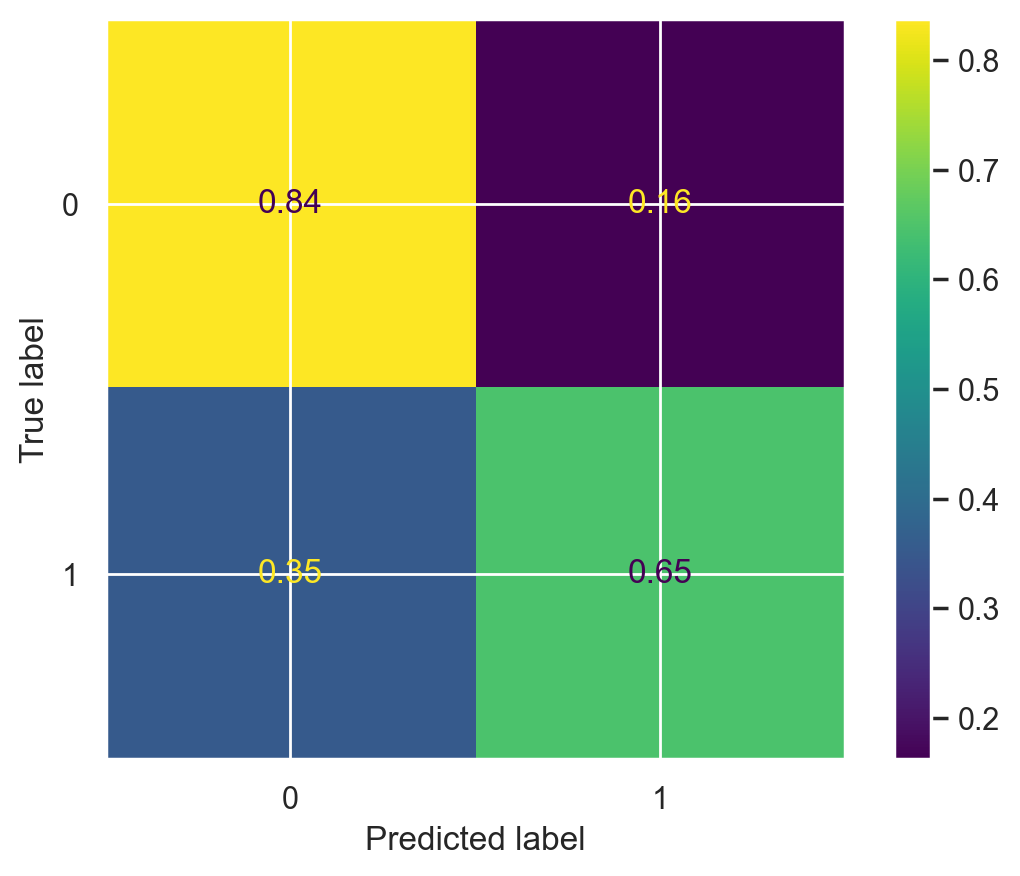

In [19]:
test_predictions = manager.base_pipeline.predict(X_test)
plot_confusion_table(y_test, test_predictions)

This classifier's skill is better in peformance than previous ones for reaching churned customers.